In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

# test_sample_ratio = 0.40

run_tables = False

Welcome to JupyROOT 6.22/06
{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Event selection

In [3]:
def select_events( df_events, label_jet=None, label_muon=None ):
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
        
    deltaPhi_jet_muon_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "muon0_phi"] )
    msk_dphi_ = ( deltaPhi_jet_muon_ < -np.pi )
    deltaPhi_jet_muon_.loc[ msk_dphi_ ] = deltaPhi_jet_muon_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_muon_ >= np.pi )
    deltaPhi_jet_muon_.loc[ msk_dphi_ ] = deltaPhi_jet_muon_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_muon_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, "muon0_eta"] )
    deltaR_jet_muon_ = np.sqrt( ( deltaPhi_jet_muon_ ) ** 2 + ( deltaEta_jet_muon_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    msk_muon_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                  ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                  ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_muon_ = ( deltaR_jet_muon_ >= np.pi/2 )
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    msk_tau21_       = ( jet0_tau21_ <= 0.60 )
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 4 )
#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )
    
    masks_ = [ msk_All_, msk_muon_, msk_jet_, msk_jet_muon_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    selection_keys_ = [ "All", "Muon", "Jet", "Jet_Muon", "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [4]:
run_tables = False

#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/12 21:27:06
Total time elapsed: 0
2021/05/12 21:27:07
Total time elapsed: 0
2021/05/12 21:27:07
Total time elapsed: 1


In [5]:
label_ = "GGToWW-AQGC-A0W1e-6"
columns_protons_multiRP =  df_signals_protons_multiRP_index[ label_ ].columns.values
print ( columns_protons_multiRP )
# df_signals_protons_multiRP_index[ label_ ]
df_signals_protons_multiRP_index[ label_ ][ [ 'run_mc', 'crossingAngle', 'period', 'within_aperture' ] ]

['crossingAngle' 'xi' 'thx' 'thy' 't' 'ismultirp' 'rpid' 'arm' 'random'
 'jet0_pt' 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'muon0_pt' 'muon0_eta' 'muon0_phi'
 'muon0_energy' 'muon0_charge' 'muon0_iso' 'muon0_dxy' 'muon0_dz' 'met'
 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8' 'num_bjets_ak4'
 'num_jets_ak4' 'pfcand_nextracks' 'pfcand_nextracks_noDRl' 'recoMWhad'
 'recoMWlep' 'recoMWW' 'recoRapidityWW' 'dphiWW' 'WLeptonicPt'
 'WLeptonicEta' 'WLeptonicPhi' 'pileupWeight' 'mc_pu_trueinteractions'
 'mcWeight' 'run_mc' 'jet0_jer_res' 'jet0_jer_sf' 'jet0_jer_sfup'
 'jet0_jer_sfdown' 'trackx1' 'tracky1' 'trackpixshift1' 'rpid1' 'trackx2'
 'tracky2' 'trackpixshift2' 'rpid2' 'period' 'jet0_unc' 'jet0_pt_nom'
 'jet0_energy_nom' 'jet0_mass_nom' 'jet0_corrmass_nom' 'jet0_px_nom'
 'jet0_py_nom' 'jet0_pz_nom' 'jet0_pt_jes_up' 'jet0_energy_jes_up'
 'jet0_mass_jes_up' 'jet0_corrmass_jes_up' 'jet0_px_jes_up'
 'jet0_py_jes_up' 'jet0

run_mc  crossingAngle  period  within_aperture
run lumiblock event  slice                                                
1   2266      226549 0      302030          120.0   2017D             True
              226551 0      305965          120.0  2017F3             True
                     0      305965          120.0  2017F3             True
    2267      226605 0      305178          120.0  2017F2             True
              226690 0      299337          120.0  2017C1             True
    2268      226716 0      305178          150.0  2017F2             True
              226773 0      303435          150.0   2017E             True
    2270      226932 0      297020          130.0   2017B             True
                     0      297020          130.0   2017B             True
    2273      227227 0      305178          130.0  2017F2             True
                     0      305178          130.0  2017F2             True
    2274      227321 0      299337          150.0  2017C1             True
              227328 0      299337          150.0  2017C1             True
              227324 0      303435          150.0   2017E             True
    2275      227457 0      303435          150.0   2017E             True
                     0      303435          150.0   2017E             True
    2276      227546 0      300806          140.0  2017C2             True
                     0      300806          140.0  2017C2             True
              227579 0      303435          140.0   2017E             True
                     0      303435          140.0   2017E             True
    2277      227611 0      299337          130.0  2017C1             True
              227610 0      300806          130.0  2017C2             True
              227661 0      302030          130.0   2017D             True
    2278      227745 0      303435          150.0   2017E             True
    2279      227825 0      299337          130.0  2017C1             True
              227868 0      303435          130.0   2017E             True
    2280      227969 0      303435          120.0   2017E             True
    2282      228117 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
              228121 0      299337          130.0  2017C1             True
...                            ...            ...     ...              ...
    9019      401833 0      303435          130.0   2017E             True
              401874 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
    9021      402066 0      303435          119.0   2017E             True
                     0      303435          119.0   2017E             True
              402070 0      303435          119.0   2017E             True
              402092 0      303435          119.0   2017E             True
    9024      402306 0      305965          150.0  2017F3             True
              402311 0      302030          150.0   2017D             True
              402331 0      305178          150.0  2017F2             True
              402381 0      302030          150.0   2017D             True
    9026      402504 0      303435          150.0   2017E             True
    9039      403821 0      302030          130.0   2017D             True
    9041      404017 0      297020          130.0   2017B             True
              404092 0      302030          130.0   2017D             True
              404091 0      305178          130.0  2017F2             True
    9042      404200 0      303435          140.0   2017E             True
    9043      404249 0      305178          140.0  2017F2             True
    9049      404804 0      305178          120.0  2017F2             True
              404867 0      299337          120.0  2017C1             True
              404859 0      305178          120.0  20

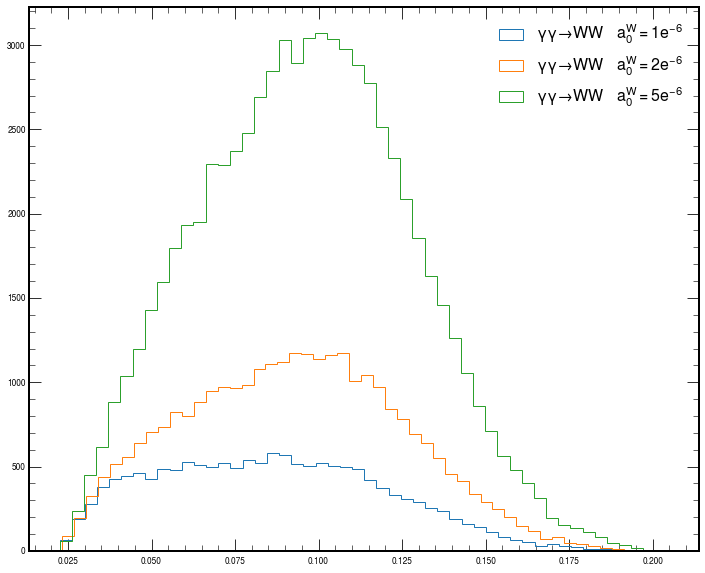

In [6]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Ouf of acceptance protons

In [ ]:
# df_signals_protons_multiRP_index_2protons = {}
# df_signals_protons_multiRP_index_1proton_Arm0 = {}
# df_signals_protons_multiRP_index_1proton_Arm1 = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     msk_1proton_Arm0_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) == 0 ) )
#     msk_1proton_Arm1_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     print ( msk_2protons_ )
#     print ( msk_1proton_Arm0_ )
#     print ( msk_1proton_Arm1_ )
#     df_signals_protons_multiRP_index_2protons[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_2protons_ ]
#     df_signals_protons_multiRP_index_1proton_Arm0[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm0_ ]
#     df_signals_protons_multiRP_index_1proton_Arm1[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm1_ ]

In [ ]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index_2protons[ label_ ]

In [ ]:
# df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]

In [ ]:
# df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]

In [ ]:
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_2protons
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm0
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm1
# fig = plt.figure( figsize=(12,10) )
# for label_ in labels_signals: 
#     plt.hist( df_signals_protons_multiRP_index_[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
# plt.legend( loc='best', fontsize=16 )

### Signal with mixed protons

In [ ]:
run_tables = False

# labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6" ]
labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6", "GGToWW-AQGC-mix_protons-A0W2e-6", "GGToWW-AQGC-mix_protons-A0W5e-6" ]

fileNames_signals = {
    "GGToWW-AQGC-mix_protons-A0W1e-6": [ "output-GGToWW-AQGC-mix_protons-A0W1e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W2e-6": [ "output-GGToWW-AQGC-mix_protons-A0W2e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W5e-6": [ "output-GGToWW-AQGC-mix_protons-A0W5e-6.h5" ]
    }

df_counts_signals_mix_protons = {}
df_signals_protons_multiRP_mix_protons_index = {}
df_signals_protons_multiRP_mix_protons_events = {}

for label_ in labels_signals_mix_protons:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, mix_protons=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals_mix_protons[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_mix_protons_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_mix_protons_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

In [ ]:
label_signal_to_mix_protons = {
     "GGToWW-AQGC-A0W1e-6" : "GGToWW-AQGC-mix_protons-A0W1e-6",
     "GGToWW-AQGC-A0W2e-6" : "GGToWW-AQGC-mix_protons-A0W2e-6",
     "GGToWW-AQGC-A0W5e-6" : "GGToWW-AQGC-mix_protons-A0W5e-6"
}

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

In [ ]:
df_signals_protons_multiRP_mix_protons_events[ label_signal_to_mix_protons[ label_ ] ]

In [ ]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = "GGToWW-AQGC-mix_protons-A0W1e-6"

# df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
# df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm0_ = df_sig_2protons_arm0_.index
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
# df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm1_ = df_sig_2protons_arm1_.index

# df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
# index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
# df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
# index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

# df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
# df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm0_ = df_mix_arm0_.index
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
# df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm1_ = df_mix_arm1_.index

In [ ]:
# msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
# df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
# df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()

# msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
# msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
# df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()

In [ ]:
# msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
# msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
# msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
# msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
# msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
# msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
# msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
# msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm1_ ) )
# print ( np.sum( ~msk_mix_arm0_ ) )
# print ( np.sum( ~msk_mix_arm1_ ) )
# # df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
# # df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]

In [ ]:
# msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
# msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
# msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
# df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
# df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
# df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
# df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

In [ ]:
# msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
# msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
# df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()

In [ ]:
# msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()

In [ ]:
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
# df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
# df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_mix_Arm0_Arm1 = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()

In [ ]:
# def concatenate_sig_mix( label_, label_mix_protons_ ):
#     df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
#     df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm0_ = df_sig_2protons_arm0_.index
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
#     df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm1_ = df_sig_2protons_arm1_.index

#     df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
#     index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
#     df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
#     index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

#     df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
#     df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm0_ = df_mix_arm0_.index
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
#     df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm1_ = df_mix_arm1_.index
    
#     # 1 proton in Arm 0, mix in Arm 1
#     msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
#     df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
#     msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()
    
#     # 0 protons
#     msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
#     msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
#     msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
#     msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
#     msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
#     msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
#     msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
#     msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_ ) )
#     print ( np.sum( ~msk_mix_arm0_ ) )
#     print ( np.sum( ~msk_mix_arm1_ ) )
#     df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
#     df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]   
#     df_0protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_0protons_, df_mix_arm1_sig_0protons_ ] ).sort_index()
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0

#     # 2 protons, 1 misreconstructed
#     msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
#     msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
#     msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
#     df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
#     df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
#     df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

#     # 1 proton in Arm 0 misreconstructed, mix in Arm 1
#     msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
#     msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1 misreconstructed, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()    
    
#     # 2 protons, both misreconstructed
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
#     df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()
    
#     return ( df_1proton_Arm0_mix_Arm1_,
#              df_1proton_Arm1_mix_Arm0_,
#              df_0protons_mix_Arm0_Arm1_,
#              df_2protons_Arm0_mix_Arm1_,
#              df_2protons_Arm1_mix_Arm0_,
#              df_1proton_Arm0_mix_Arm0_Arm1_,
#              df_1proton_Arm1_mix_Arm1_Arm0_,
#              df_2protons_mix_Arm0_Arm1_
#            )

In [ ]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
# df_1proton_Arm0_mix_Arm1_, df_1proton_Arm1_mix_Arm0_, df_0protons_mix_Arm0_Arm1_, df_2protons_Arm0_mix_Arm1_, df_2protons_Arm1_mix_Arm0_, df_1proton_Arm0_mix_Arm0_Arm1_, df_1proton_Arm1_mix_Arm1_Arm0_, df_2protons_mix_Arm0_Arm1_ = concatenate_sig_mix( label_, label_mix_protons_ )

In [ ]:
# df_1proton_Arm0_mix_Arm1_
# # df_1proton_Arm0_mix_Arm1_[ [ "eff_proton_all", "eff_multitrack" ] ]

In [ ]:
# df_1proton_Arm1_mix_Arm0_
# # df_1proton_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [ ]:
# df_0protons_mix_Arm0_Arm1_
# # df_0protons_mix_Arm0_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [ ]:
# df_2protons_Arm0_mix_Arm1_
# # df_2protons_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [ ]:
# df_2protons_Arm1_mix_Arm0_
# # df_2protons_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [ ]:
# df_1proton_Arm0_mix_Arm0_Arm1_

In [ ]:
# df_1proton_Arm1_mix_Arm1_Arm0_

In [ ]:
# df_2protons_mix_Arm0_Arm1_[ ['crossingAngle', 'crossingAngle_rnd'] ]

In [ ]:
# labels_out_acceptance_misreconstructed_ = ( "1proton_Arm0_mix_Arm1", "1proton_Arm1_mix_Arm0", "0protons_mix_Arm0_Arm1",
#                                             "2protons_Arm0_mix_Arm1", "2protons_Arm1_mix_Arm0",
#                                             "1proton_Arm0_mix_Arm0_Arm1", "1proton_Arm1_mix_Arm1_Arm0", "2protons_mix_Arm0_Arm1" )

# df_signals_protons_multiRP_out_acceptance_misreconstructed = {}

# for label_ in labels_signals:
#     print ( label_ )
#     label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
#     df_signals_protons_multiRP_out_acceptance_misreconstructed__ = concatenate_sig_mix( label_, label_mix_protons_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ] = {}
#     for idx_, df__ in enumerate( df_signals_protons_multiRP_out_acceptance_misreconstructed__ ):
#         print ( labels_out_acceptance_misreconstructed_[ idx_ ] )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ labels_out_acceptance_misreconstructed_[ idx_ ] ] = df__

In [ ]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]:
#     print ( key_ )
#     df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#     plt.hist( df__[ 'xi' ], histtype='step', bins=50, label=key_ )
# plt.legend( loc='best', fontsize=16 )

In [ ]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_index[ label_ ].columns
# columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

# columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
#                   "trackx1", "tracky1", "trackpixshift1", "rpid1",
#                   "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
# columns_drop_eff_ = columns_drop_.copy()
# columns_drop_eff_.extend( columns_eff_ )

# df_signals_protons_multiRP_out_acceptance_misreconstructed_events = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]: 
#         print ( key_ )
#         columns_drop__ = columns_drop_ if key_ in ( '0protons_mix_Arm0_Arm1', '1proton_Arm0_mix_Arm0_Arm1', '1proton_Arm1_mix_Arm1_Arm0', '2protons_mix_Arm0_Arm1' ) else columns_drop_eff_
#         df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#         df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ] = df_protons_multiRP_events__

### Signal with event mixing

In [ ]:
df_signals_protons_multiRP_eff_sel_index = {}
df_signals_protons_multiRP_sig_plus_mix_index = {}

np.random.seed( 12345 )

for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero_weighted" ] = 1.0
    
    msk_eff_proton_ = np.random.rand( df_signals_protons_multiRP_index[ label_ ].shape[0] ) < df_signals_protons_multiRP_index[ label_ ].loc[ :, "eff_proton_all" ]
    print ( msk_eff_proton_ )
    df_signals_protons_multiRP_eff_sel_index[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_eff_proton_ ]

#     df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
#         [ df_signals_protons_multiRP_index[ label_ ],
#           df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()
    df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
        [ df_signals_protons_multiRP_eff_sel_index[ label_ ],
          df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_index[ label_ ]

In [ ]:
df_signals_protons_multiRP_eff_sel_index[ label_ ]

In [ ]:
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_index[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_2protons = {}
for label_ in labels_signals:
    print ( label_ )
    df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_2protons_single_proton_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) & ( np.sum( s_ == 1 ) == 1 ) )
    print ( msk_2protons_single_proton_, np.sum( msk_2protons_single_proton_ ) )
    df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ] = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].loc[ msk_2protons_single_proton_ ]

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_2protons_sig = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0 = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1 = {}
df_signals_protons_multiRP_sig_plus_mix_2protons_mix = {}
for label_ in labels_signals:
    print ( label_ )
#     df_protons_multiRP_groupby_random_ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ "random" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 2 ) )
#     msk_1proton_sig_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) )
#     msk_2protons_mix_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) )
#     print ( msk_2protons_, np.sum( msk_2protons_ ) )
#     print ( msk_1proton_sig_, np.sum( msk_1proton_sig_ ) )
#     print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_groupby__ = df__[ [ "arm", "random" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_sig_Arm0_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 0 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_sig_Arm1_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 1 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_2protons_ = ( msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_1proton_sig_Arm0_ = ( msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    msk_1proton_sig_Arm1_ = ( ~msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_2protons_mix_ = ( ~msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    print ( msk_2protons_, np.sum( msk_2protons_ ) )
    print ( msk_1proton_sig_Arm0_, np.sum( msk_1proton_sig_Arm0_ ) )
    print ( msk_1proton_sig_Arm1_, np.sum( msk_1proton_sig_Arm1_ ) )
    print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ] = df__.loc[ msk_2protons_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ] = df__.loc[ msk_1proton_sig_Arm0_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ] = df__.loc[ msk_1proton_sig_Arm1_ ]
    df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ] = df__.loc[ msk_2protons_mix_ ]

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [7]:
run_tables = False

label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].columns
columns_ = columns_protons_multiRP
columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]
columns_xi_  = columns_[ [ key_[ : len('xi_') ] == 'xi_' for key_ in columns_ ] ]

columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
                  "trackx1", "tracky1", "trackpixshift1", "rpid1",
                  "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
columns_drop_eff_xi_ = columns_drop_.copy()
columns_drop_eff_xi_.extend( columns_eff_ )
columns_drop_eff_xi_.extend( columns_xi_ )

df_signals_protons_multiRP_sig_plus_mix_2protons_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events = {}
df_signals_protons_multiRP_sig_plus_mix_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    if run_tables:
        with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), complevel=5 ) as store_:
            df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
            df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = df_protons_multiRP_events__

            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
            print ( "2protons_sig" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ] = df_protons_multiRP_events__
            print ( "1proton_sig_Arm0" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ] = df_protons_multiRP_events__
            print ( "1proton_sig_Arm1" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ] = df_protons_multiRP_events__
            print ( "2protons_mix" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ] = df_protons_multiRP_events__
            
            store_[ "events_multiRP/all" ] = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
            for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
                store_[ "events_multiRP/{}".format( key_ ) ] = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]
    else:
        with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), 'r' ) as store_:
            df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = store_[ "/events_multiRP/all" ]
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
            for key_ in [ '2protons_sig', '1proton_sig_Arm0', '1proton_sig_Arm1', '2protons_mix' ]:
                print ( key_ )
                df_protons_multiRP_events__ = store_[ "events_multiRP/{}".format( key_ ) ]
                df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ] = df_protons_multiRP_events__

GGToWW-AQGC-A0W1e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


In [8]:
# # Save data frames
# if save_tables:
#     for label_ in labels_signals:
#         with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), complevel=5 ) as store_:
#             store_[ "events_multiRP/all" ] = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
#             for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
#                 store_[ "events_multiRP/{}".format( key_ ) ] = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]

In [9]:
if run_tables:
    for label_ in labels_signals:
        with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), 'r' ) as store_:
            print ( list( store_ ) )

In [10]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    13        1220   0       785.503459   785.533833   785.520325   
    15        1413   0       663.856206   663.957635   663.908569   
    29        2846   0       676.290448   676.285556   676.292053   
    34        3364   0      1474.120975  1473.956945  1474.041016   
    39        3832   0       465.009265   464.975375   464.994293   
    45        4462   0       879.668721   879.614006   879.642761   
    47        4636   0      1413.988301  1414.015157  1414.002930   
    50        4970   0       590.643830   590.481086   590.564575   
    52        5147   0      2208.462721  2208.497132  2208.482666   
    54        5302   0       494.383991   494.190179   494.289062   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    93        9298   0      1869.307738  1869.280494  1869.295532   
    98        9713   0      1191.212674  1191.220291  1191.219604   
              9730   0      1018.503338  1018.488729  1018.498352   
    103       10231  0       495.220340   495.218535   495.221222   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    109       10818  0      1217.808375  1217.764914  1217.787842   
    113       11246  0      1714.341838  1714.307527  1714.332520   
    114       11390  0      1503.235649  1503.124267  1503.182617   
    118       11748  0       928.685807   928.528880   928.608948   
    121       12011  0       525.085596   525.064398   525.076965   
    129       12850  0       632.720872   632.788313   632.756775   
    130       12922  0      1476.695676  1476.638553  1476.667969   
    137       13645  0      1969.734998  1969.301475  1969.527832   
    141       14060  0       949.875376   949.973979   949.926697   
    145       14421  0       534.835283   534.653308   534.746216   
    158       15790  0      1256.363224  1256.337456  1256.352295   
...                                 ...          ...          ...   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9884      488363 0      1825.726642  1825.704425  1825.724487   
    9886      488565 0       491.249103   491.421030   491.337036   
    9887      488636 0       685.137927   685.189303   685.165283   
              488668 0      1192.621614  1192.331154  1192.479614   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9893      489297 0       488.384260   488.388739   488.388519   
    9896      489544 0      1845.393980  1845.463345  1845.432983   
              489556 0      1134.427607  1134.419089  1134.424805   
    9897      489689 0       686.084964   686.141451   686.115234   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0      1774.470935  1774.302288  1774.391968   
    9908      490767 0      1713.075727  1713.005109  1713.046143   
    9915      491493 0      1849.839611  1848.812099  1849.331787   
    9921      492078 0      1113.667724  1113.554779  1113.614502   
    9922      492154 0      1651.715009  1651.598760  1651.662109   
    9928      492715 0      1434.039601  1434.017436  1434.032104   
    9937      493601 0      1923.765540  1923.650004  1923.718872   
    9942      494129 0       497.784674   497.767029   497.777710   
    9950      494979 0       671.072966   671.025022   671.050964   
    9956      495568 0      1240.252214  1240.133735  1240.194824   
    9965      496415 0      1319.437675  1319.417003  1319.428345   
    9966      496511 0      1854.588147  1854.217668  1854.408203   
    9968      496707 0      2042.087823  2041.871722  2041.984497   
    9970      496950 0      1185.053633  1185.207458  1185.132935   
    9977      497640 0     

In [11]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    15        1413   0       663.856206   663.957635   663.908569   
    45        4462   0       879.668721   879.614006   879.642761   
    54        5302   0       494.383991   494.190179   494.289062   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    109       10818  0      1217.808375  1217.764914  1217.787842   
    118       11748  0       928.685807   928.528880   928.608948   
    121       12011  0       525.085596   525.064398   525.076965   
    141       14060  0       949.875376   949.973979   949.926697   
    158       15790  0      1256.363224  1256.337456  1256.352295   
    159       15886  0       965.286082   965.299631   965.294250   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    180       17927  0      1309.259792  1309.244596  1309.255493   
    185       18450  0       741.100570   740.906564   741.005554   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    254       25349  0      1224.206523  1224.152632  1224.181396   
    255       25410  0       902.686651   902.661607   902.675049   
    290       28991  0       767.500262   767.457384   767.481323   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    327       32601  0       744.111599   744.025875   744.071045   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    378       37708  0       462.376010   462.366872   462.373657   
    391       39018  0      1686.268130  1686.197796  1686.236816   
    392       39191  0      1052.976220  1052.930319  1052.955688   
    429       42811  0      1595.788632  1595.821810  1595.808960   
...                                 ...          ...          ...   
    9755      475427 0       737.038030   737.008723   737.025452   
    9756      475599 0       797.326903   797.357980   797.344543   
    9757      475659 0       712.406315   712.358451   712.385254   
    9762      476192 0      1355.977812  1355.824720  1355.904541   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9788      478707 0      1126.210397  1126.221934  1126.218628   
    9790      478941 0       758.642445   758.165809   758.406494   
    9797      479689 0       752.730445   752.710366   752.722656   
    9832      483122 0      1167.197398  1167.321921  1167.262207   
    9835      483494 0       947.816400   947.774747   947.797852   
    9838      483718 0      1298.873741  1298.873537  1298.875732   
    9846      484524 0       629.956540   629.908122   629.934692   
    9853      485253 0       637.846683   637.641218   637.745667   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9860      485910 0       702.917591   702.580927   702.750854   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9864      486374 0      1243.433268  1243.431790  1243.434082   
    9877      487666 0      1403.676289  1403.657809  1403.670166   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9887      488636 0       685.137927   685.189303   685.165283   
              488668 0      1192.621614  1192.331154  1192.479614   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0      1774.470935  1774.302288  1774.391968   
    9922      492154 0      1651.715009  1651.598760  1651.662109   
    9928      492715 0     

In [12]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   29        2846   0       676.290448   676.285556   676.292053   
    34        3364   0      1474.120975  1473.956945  1474.041016   
    39        3832   0       465.009265   464.975375   464.994293   
    47        4636   0      1413.988301  1414.015157  1414.002930   
    129       12850  0       632.720872   632.788313   632.756775   
    130       12922  0      1476.695676  1476.638553  1476.667969   
    137       13645  0      1969.734998  1969.301475  1969.527832   
    145       14421  0       534.835283   534.653308   534.746216   
    187       18665  0       469.136521   469.100063   469.120270   
    209       20845  0       872.834025   872.735775   872.787231   
    248       24707  0       628.321424   628.207200   628.266235   
    262       26119  0      1443.355999  1443.346067  1443.352173   
    268       26800  0      1783.024997  1782.996784  1783.015259   
    269       26883  0       512.119364   512.224651   512.173889   
    309       30888  0       655.235001   655.208625   655.223694   
    329       32851  0      1083.618836  1083.529208  1083.576172   
    394       39329  0      1738.045367  1738.126791  1738.090332   
    396       39544  0      1531.688330  1531.599236  1531.650269   
    398       39761  0       671.391989   671.350135   671.372986   
    412       41169  0       780.693847   780.650374   780.674072   
    449       44888  0       567.472511   567.446693   567.461487   
    503       50273  0       536.320518   536.322434   536.323547   
    507       50616  0      1390.644375  1390.241012  1390.446045   
    517       51651  0       612.780392   612.682705   612.733826   
    523       52244  0      1593.821663  1593.822012  1593.824585   
    525       52425  0       608.934060   608.969412   608.953613   
    539       53899  0      1545.448339  1545.176688  1545.317871   
    547       54642  0      1747.283265  1747.127332  1747.211548   
    559       55866  0      1451.639431  1451.630794  1451.637207   
    564       56357  0      1482.996899  1482.857573  1482.932861   
...                                 ...          ...          ...   
    9129      412882 0      1415.884878  1415.761076  1415.826660   
    9159      415836 0       500.239868   500.138562   500.191284   
    9237      423679 0      1465.014542  1465.004950  1465.012451   
    9269      426885 0      1615.842776  1615.779247  1615.813843   
    9332      433174 0       794.855752   794.899228   794.881348   
    9384      438326 0      1888.829622  1888.770367  1888.803101   
    9400      439995 0      1166.154093  1166.020504  1166.090210   
    9406      440554 0      1394.676992  1394.654894  1394.670532   
    9432      443191 0       766.559160   766.432766   766.497925   
    9436      443545 0      1497.932135  1497.944578  1497.943115   
    9451      445007 0       485.385592   485.479471   485.434387   
    9493      449244 0       499.332191   499.325558   499.330902   
    9501      450020 0       499.070783   499.038079   499.056702   
    9504      450305 0      1406.561194  1406.583675  1406.577393   
    9514      451329 0       499.236912   499.278965   499.260040   
    9516      451598 0      1327.576174  1327.507155  1327.543335   
    9573      457297 0       806.571821   806.451651   806.513367   
    9590      458995 0      1394.491261  1394.434532  1394.466064   
    9643      464294 0       517.191927   517.314028   517.254822   
    9656      465557 0      1495.780383  1495.801106  1495.792969   
    9685      468481 0      1593.942674  1593.090922  1593.522339   
    9689      468865 0       477.763764   477.623741   477.695892   
    9742      474128 0       888.005272   887.993442   888.000671   
    9789      478817 0       714.041927   713.876638   713.961853   
    9795      479435 0      1013.693731  1013.495408  1013.596741   
    9849      484842 0     

In [13]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   13        1220   0       785.503459   785.533833   785.520325   
    50        4970   0       590.643830   590.481086   590.564575   
    93        9298   0      1869.307738  1869.280494  1869.295532   
    103       10231  0       495.220340   495.218535   495.221222   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    113       11246  0      1714.341838  1714.307527  1714.332520   
    184       18330  0      1380.604934  1380.492519  1380.553833   
    202       20175  0      1392.105664  1391.498102  1391.807373   
    215       21403  0      1847.912272  1846.494972  1847.217529   
    217       21614  0      1018.136650  1018.056210  1018.098083   
    281       28069  0      1054.803704  1054.776851  1054.792114   
    294       29320  0      1457.400263  1457.022252  1457.217773   
    336       33510  0       921.393033   921.254909   921.327454   
    347       34627  0      1541.254829  1540.665223  1540.967163   
    371       37054  0      2212.136981  2211.605021  2211.887207   
              37069  0       443.388122   443.320351   443.356354   
    377       37602  0      1698.029995  1698.101264  1698.069824   
    392       39115  0      1786.340075  1785.934867  1786.143066   
    420       41943  0      1784.664994  1784.664776  1784.670898   
    434       43368  0      1632.671512  1631.739277  1632.213013   
    442       44146  0      1527.403140  1527.481143  1527.444214   
    455       45491  0      1092.377806  1092.301907  1092.341553   
    456       45516  0      1682.898490  1682.917921  1682.912842   
    464       46380  0      2072.565017  2072.538106  2072.555664   
    481       48044  0      2079.967797  2079.760007  2079.870850   
    484       48349  0      1355.576278  1355.528618  1355.556030   
    533       53281  0       481.468177   481.372026   481.422455   
    550       54946  0      1550.076778  1549.897934  1549.991577   
    567       56606  0      1909.198086  1908.955808  1909.086182   
    571       57047  0      1632.847492  1632.701427  1632.778809   
...                                 ...          ...          ...   
    9612      461110 0      1565.880547  1565.773788  1565.833984   
    9613      461261 0      2253.401789  2252.415543  2252.919678   
    9618      461786 0      1155.835483  1155.754963  1155.798218   
    9622      462120 0      1543.084961  1543.102357  1543.095825   
    9666      466587 0      1713.705595  1713.661418  1713.688965   
    9672      467154 0       845.295972   845.264700   845.281921   
    9705      470457 0      1238.318086  1238.336188  1238.329956   
    9712      471143 0      1669.033806  1668.948460  1668.993530   
    9723      472233 0      1078.493534  1078.359794  1078.430542   
    9752      475123 0      1674.567995  1674.424856  1674.501099   
    9774      477382 0      1588.122839  1588.161110  1588.145752   
    9792      479188 0      1727.923802  1727.932913  1727.931519   
    9802      480127 0      1338.199005  1338.226819  1338.216309   
    9808      480745 0       708.166904   708.036618   708.103027   
    9821      482080 0      1293.736150  1293.622510  1293.683960   
    9831      483027 0       423.229327   423.038994   423.136536   
    9843      484259 0      1478.382918  1478.452483  1478.420776   
    9866      486578 0      1308.336830  1306.882909  1307.617310   
    9868      486713 0      1169.068134  1169.252482  1169.162476   
    9872      487197 0       552.938505   552.957588   552.949585   
    9884      488363 0      1825.726642  1825.704425  1825.724487   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9896      489556 0      1134.427607  1134.419089  1134.424805   
    9921      492078 0      1113.667724  1113.554779  1113.614502   
    9937      493601 0      1923.765540  1923.650004  1923.718872   
    9956      495568 0     

In [14]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   52        5147   0      2208.462721  2208.497132  2208.482666   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    98        9713   0      1191.212674  1191.220291  1191.219604   
    114       11390  0      1503.235649  1503.124267  1503.182617   
    199       19891  0      2106.913639  2106.554662  2106.748779   
    278       27780  0      2164.714984  2164.774293  2164.759033   
    336       33511  0      2112.622783  2112.723490  2112.677979   
    353       35209  0       868.962803   868.999872   868.985779   
    375       37430  0       494.031512   493.673750   493.855255   
    419       41862  0      2891.880306  2891.753785  2891.829590   
    446       44582  0      1676.390852  1676.422598  1676.412598   
    477       47623  0       697.035661   696.942087   696.992065   
    585       58454  0      2106.706541  2105.897913  2106.313721   
    603       60281  0      2342.644313  2342.539799  2342.609131   
    608       60795  0      2147.993650  2147.788740  2147.895264   
    627       62645  0      1346.524309  1346.576463  1346.551758   
    654       65335  0      1812.769706  1812.698382  1812.735840   
    696       69578  0      1800.858464  1800.222331  1800.546143   
    739       73867  0      2379.203065  2378.966322  2379.096680   
    765       76451  0      2105.521505  2104.836883  2105.189209   
    768       76777  0      1896.400218  1896.524104  1896.470337   
    805       80422  0       815.093539   815.059645   815.080139   
    809       80802  0      1594.549432  1594.347886  1594.451538   
    844       84375  0       899.439946   899.343679   899.394775   
    878       87762  0      2205.531657  2205.530850  2205.534912   
    945       94436  0      2138.357089  2138.389398  2138.382568   
    984       98349  0       680.116865   680.051242   680.085754   
    1023      102256 0      2059.914887  2059.859043  2059.898193   
    1024      102313 0      2229.740037  2228.899585  2229.329102   
...                                 ...          ...          ...   
    9103      410254 0      1146.389714  1146.272973  1146.332520   
    9112      411105 0      1408.711765  1408.488249  1408.603638   
    9115      411414 0      1664.017551  1663.065786  1663.547974   
    9148      414772 0      1779.707423  1779.547648  1779.632080   
    9205      420500 0      1678.602595  1678.511286  1678.559082   
    9274      427394 0       902.150599   902.151076   902.152100   
    9299      429846 0      1874.386230  1874.232955  1874.313721   
    9316      431577 0       607.180121   607.280713   607.234741   
    9477      447615 0       686.562782   686.302011   686.435120   
    9487      448635 0      2433.950391  2433.797997  2433.893311   
    9517      451674 0      1961.614002  1961.189114  1961.408325   
    9544      454366 0      1865.047478  1864.760250  1864.914307   
    9549      454832 0      2066.368358  2066.387105  2066.384277   
    9556      455505 0      2138.590531  2138.700911  2138.658936   
    9588      458797 0      1482.663970  1482.700650  1482.684570   
    9614      461336 0       769.125374   768.956126   769.044434   
    9636      463502 0      2003.182462  2003.167117  2003.181641   
              463573 0      2162.868655  2162.948279  2162.922119   
    9648      464785 0       560.389166   560.302310   560.347351   
    9657      465618 0      1184.004786  1183.854777  1183.932007   
    9660      465903 0      1757.999786  1758.261069  1758.138306   
              465920 0      1068.583517  1068.420063  1068.504272   
    9665      466435 0      1211.950749  1211.947203  1211.952393   
    9720      471972 0      2512.218700  2512.051314  2512.147949   
    9828      482775 0      1856.876213  1856.931048  1856.910034   
    9886      488565 0     

### Select events

In [15]:
selection_keys_signals = {}
selections_signals = {}
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ], selection_keys_signals[ label_ ], selections_signals[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

3294
1366
5555
2488
12550
5927


In [16]:
print ( selection_keys_signals )
print ( selections_signals )

{'GGToWW-AQGC-A0W1e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W2e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W5e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']}
{'GGToWW-AQGC-A0W1e-6': {'All': 3294, 'Muon': 3294, 'Jet': 3294, 'Jet_Muon': 3292, 'MET': 2920, 'Jet_MET': 2828, 'PrunedMass': 2045, 'Tau21': 1899, 'BJet_Veto': 1899, 'Xi_CMS': 1896, 'WLeptonic': 1837, 'Jet_WLeptonic': 1837, 'MWW': 1814, 'ExtraTracks': 1366}, 'GGToWW-AQGC-A0W2e-6': {'All': 5555, 'Muon': 5555, 'Jet': 5555, 'Jet_Muon': 5554, 'MET': 5034, 'Jet_MET': 4828, 'PrunedMass': 3607, 'Tau21': 3342, 'BJet_Veto': 3342, 'Xi_CMS': 3340, 'WLeptonic': 3265, 'Jet_WLeptoni

In [17]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events = {}
# for label_ in labels_signals:
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ]: 
#         print ( key_ )
#         df_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ]
#         print ( df_events__.shape[0] )
#         df_selected_events__, selection_keys__, selections__ = select_events( df_events__ )
#         print ( df_selected_events__.shape[0] )
#         print ( selection_keys__ )
#         print ( selections__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ] = df_selected_events__

In [18]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_selected_events = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw" ] }
for label_ in labels_signals:
    print ( label_ )
    df_events__ = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ] = {}
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__  = select_events( df_events__, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ] = df_selected_events__
            
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] = {}
    for cat__ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
        print ( cat__ )
        df_events__ = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ cat__ ]
        print ( df_events__.shape[0] )
        df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
        print ( df_selected_events__.shape[0] )
        print ( selection_keys__ )
        print ( selections__ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ] = {}
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ "_nom" ] = df_selected_events__
        for var_label__ in variations_:
            print ( var_label__ )
            for variation__ in variations_[ var_label__ ]:
                opt__ = { "label_" + var_label__ : variation__ }
                print ( opt__ )
                df_selected_events__, selection_keys__, selections__  = select_events( df_events__, **opt__ )
                print ( df_selected_events__.shape[0] )
                print ( selection_keys__ )
                print ( selections__ )
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ] = df_selected_events__

GGToWW-AQGC-A0W1e-6
2076
871
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2076, 'Muon': 2076, 'Jet': 2076, 'Jet_Muon': 2076, 'MET': 1883, 'Jet_MET': 1810, 'PrunedMass': 1329, 'Tau21': 1222, 'BJet_Veto': 1222, 'Xi_CMS': 1167, 'WLeptonic': 1139, 'Jet_WLeptonic': 1139, 'MWW': 1122, 'ExtraTracks': 871}
jet
{'label_jet': '_jes_up'}
868
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2076, 'Muon': 2076, 'Jet': 2076, 'Jet_Muon': 2076, 'MET': 1883, 'Jet_MET': 1810, 'PrunedMass': 1329, 'Tau21': 1221, 'BJet_Veto': 1221, 'Xi_CMS': 1164, 'WLeptonic': 1136, 'Jet_WLeptonic': 1136, 'MWW': 1119, 'ExtraTracks': 868}
{'label_jet': '_jes_dw'}
873
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'Ex

368
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 795, 'Muon': 795, 'Jet': 795, 'Jet_Muon': 795, 'MET': 731, 'Jet_MET': 694, 'PrunedMass': 559, 'Tau21': 504, 'BJet_Veto': 504, 'Xi_CMS': 470, 'WLeptonic': 465, 'Jet_WLeptonic': 465, 'MWW': 463, 'ExtraTracks': 368}
jet
{'label_jet': '_jes_up'}
367
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 795, 'Muon': 795, 'Jet': 795, 'Jet_Muon': 795, 'MET': 731, 'Jet_MET': 694, 'PrunedMass': 559, 'Tau21': 504, 'BJet_Veto': 504, 'Xi_CMS': 469, 'WLeptonic': 464, 'Jet_WLeptonic': 464, 'MWW': 462, 'ExtraTracks': 367}
{'label_jet': '_jes_dw'}
371
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 795, 'Muon': 795, 'Jet': 790, '

1446
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 3230, 'Muon': 3230, 'Jet': 3229, 'Jet_Muon': 3229, 'MET': 3002, 'Jet_MET': 2831, 'PrunedMass': 2168, 'Tau21': 2005, 'BJet_Veto': 2005, 'Xi_CMS': 1886, 'WLeptonic': 1879, 'Jet_WLeptonic': 1879, 'MWW': 1873, 'ExtraTracks': 1446}
2protons_mix
2203
923
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2203, 'Muon': 2203, 'Jet': 2203, 'Jet_Muon': 2203, 'MET': 2077, 'Jet_MET': 1942, 'PrunedMass': 1508, 'Tau21': 1360, 'BJet_Veto': 1360, 'Xi_CMS': 1190, 'WLeptonic': 1184, 'Jet_WLeptonic': 1184, 'MWW': 1184, 'ExtraTracks': 923}
jet
{'label_jet': '_jes_up'}
912
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2203, 'Muo

In [19]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [20]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]:
        print ( variation__ )
        df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_
    for cat__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( cat__ )
#     for cat__ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( cat__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ cat__ ].loc[ :, "norm" ] = norm_factors_product_
        for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ]:
            print ( variation__ )
            df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

37.190432966
GGToWW-AQGC-A0W1e-6
[993700.0, 0.0453974, 6]
[3.74262181e-05 4.53974000e+01 1.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


_nom
_jes_up
_jes_dw
2protons_sig
_nom
_jes_up
_jes_dw
1proton_sig_Arm0
_nom
_jes_up
_jes_dw
1proton_sig_Arm1
_nom
_jes_up
_jes_dw
2protons_mix
_nom
_jes_up
_jes_dw
GGToWW-AQGC-A0W2e-6
[880000.0, 0.0583158, 6]
[4.22618556e-05 5.83158000e+01 1.00000000e+00]
_nom
_jes_up
_jes_dw
2protons_sig
_nom
_jes_up
_jes_dw
1proton_sig_Arm0
_nom
_jes_up
_jes_dw
1proton_sig_Arm1
_nom
_jes_up
_jes_dw
2protons_mix
_nom
_jes_up
_jes_dw
GGToWW-AQGC-A0W5e-6
[993000.0, 0.148132, 6]
[3.74526012e-05 1.48132000e+02 1.00000000e+00]
_nom
_jes_up
_jes_dw
2protons_sig
_nom
_jes_up
_jes_dw
1proton_sig_Arm0
_nom
_jes_up
_jes_dw
1proton_sig_Arm1
_nom
_jes_up
_jes_dw
2protons_mix
_nom
_jes_up
_jes_dw


In [21]:
label_ = "GGToWW-AQGC-A0W1e-6"

print ( df_signals_protons_multiRP_events[ label_ ].columns )
df_signals_protons_multiRP_events[ label_ ]

Index(['crossingAngle', 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_energy',
       'jet0_mass', 'jet0_corrmass', 'jet0_tau1', 'jet0_tau2', 'jet0_vertexz',
       ...
       'YX_m100_m100', 'R_MWW_MX_m100_m100', 'Diff_YWW_YX_m100_m100',
       'eff_proton_all_weighted', 'eff_multitrack_weighted',
       'eff_strictzero_weighted', 'eff_proton_all', 'eff_multitrack',
       'eff_strictzero', 'norm'],
      dtype='object', length=163)


crossingAngle     jet0_pt  jet0_eta  jet0_phi  \
run lumiblock event  slice                                                  
1   2275      227457 0              150.0  345.850189 -1.458291  3.099098   
    2276      227579 0              140.0  819.906433  0.347934  1.723913   
    2282      228117 0              130.0  321.463196  0.091370 -2.196248   
    2286      228503 0              130.0  649.005920 -0.110481  1.066668   
              228565 0              130.0  360.785767  0.943119 -1.373860   
    2297      229605 0              120.0  314.089844 -0.833665  2.804024   
    2298      229715 0              140.0  303.292603 -0.605599  1.378168   
    2305      230479 0              120.0  711.671204 -0.083028 -2.544181   
    2316      231571 0              130.0  304.978241 -1.147173  1.442453   
    4034      403369 0              140.0  271.863373 -0.377092  2.046722   
    4054      405349 0              150.0  557.424194 -0.760342  0.956181   
    3850      384981 0              120.0  252.268082 -1.713197  2.468808   
    3852      385168 0              120.0  491.048767  0.647862  0.466178   
    3862      386166 0              150.0  635.511841  0.297460  1.661229   
              386194 0              150.0  434.129974 -0.537267 -1.875507   
    3865      386403 0              120.0  253.235092  0.857444 -1.256152   
              386463 0              120.0  735.412415 -0.658536  1.340903   
    3870      386996 0              120.0  647.854858  0.063386 -1.009207   
    4255      425453 0              130.0  307.973694 -1.193913  0.364675   
    4264      426339 0              130.0  308.640625 -0.778031 -3.126354   
              426393 0              130.0  281.545044 -1.154744  0.944827   
    4271      427010 0              130.0  675.825195 -0.473871 -0.401099   
    4273      427206 0              120.0  660.517334 -0.069177 -2.677781   
    9601      460019 0              150.0  532.998779  0.894459 -0.545929   
    9607      460669 0              150.0  287.972534 -0.907298  2.777492   
              460696 0              150.0  652.113708  0.084567 -2.959348   
    9612      461137 0              150.0  400.678864 -0.966325  2.217957   
    9579      457851 0              150.0  391.394226  1.252353  3.121012   
    9583      458238 0              150.0  293.645050 -0.989693 -2.854835   
    9616      461531 0              130.0  346.565308 -1.741414 -2.957556   
...                                   ...         ...       ...       ...   
    2441      244066 0              120.0  201.220688 -1.086019  1.898202   
    2447      244679 0              140.0  527.778687 -0.288657  1.168062   
    2480      247941 0              120.0  243.022858  0.018078  1.887087   
    2485      248478 0              130.0  478.567688  0.954942  1.670953   
    2489      248887 0              120.0  287.306885 -0.163211 -1.934245   
    2497      249670 0              150.0  367.433075 -0.681065  0.836650   
    2504      250354 0              130.0  235.296387 -0.688626  1.736146   
    2506      250534 0              150.0  348.601715 -0.520259  2.048185   
    2511      251083 0              130.0  439.048553  0.920148  0.663145   
    2522      252199 0              130.0  816.885559 -0.410688 -2.349145   
    9084      408308 0              120.0  222.487900  0.828301 -3.049489   
    9061      406041 0              130.0  303.140472 -0.741241 -2.557097   
    5664      66344  0              130.0  357.589813  0.837167  1.796901   
    5670      66951  0              120.0  539.069214  0.935207 -2.119600   
    5683      68294  0              120.0  647.558777  0.011456  0.183460   
    5685      68410  0              130.0  270.916138 -0.779387 -2.761405   
    5691      69049  0              140.0  363.316864 -0.673153  0.781148   
    5693      69229  0              130.0  240.823746 -1.861926 -1.990464   
    6229      122879 0              130.0  532.137878  0.928207  1.712423   
    6235      123449 0  

In [22]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_jes_up" ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    29        2846   0       676.290448   676.285556   676.292053   
    52        5147   0      2208.462721  2208.497132  2208.482666   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    118       11748  0       928.685807   928.528880   928.608948   
    129       12850  0       632.720872   632.788313   632.756775   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    184       18330  0      1380.604934  1380.492519  1380.553833   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    209       20845  0       872.834025   872.735775   872.787231   
    215       21403  0      1847.912272  1846.494972  1847.217529   
    217       21614  0      1018.136650  1018.056210  1018.098083   
    268       26800  0      1783.024997  1782.996784  1783.015259   
    281       28069  0      1054.803704  1054.776851  1054.792114   
    294       29320  0      1457.400263  1457.022252  1457.217773   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    329       32851  0      1083.618836  1083.529208  1083.576172   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    336       33510  0       921.393033   921.254909   921.327454   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    377       37602  0      1698.029995  1698.101264  1698.069824   
    392       39115  0      1786.340075  1785.934867  1786.143066   
    396       39544  0      1531.688330  1531.599236  1531.650269   
...                                 ...          ...          ...   
    9657      465618 0      1184.004786  1183.854777  1183.932007   
    9660      465920 0      1068.583517  1068.420063  1068.504272   
    9666      466587 0      1713.705595  1713.661418  1713.688965   
    9680      467935 0      1061.169607  1061.226514  1061.199829   
    9685      468481 0      1593.942674  1593.090922  1593.522339   
    9697      469634 0      1332.019164  1332.025524  1332.024902   
    9720      471972 0      2512.218700  2512.051314  2512.147949   
    9725      472465 0       542.738706   542.420883   542.582275   
    9741      474029 0       910.211364   910.164323   910.190002   
    9752      475123 0      1674.567995  1674.424856  1674.501099   
    9756      475599 0       797.326903   797.357980   797.344543   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9789      478817 0       714.041927   713.876638   713.961853   
    9802      480127 0      1338.199005  1338.226819  1338.216309   
    9835      483494 0       947.816400   947.774747   947.797852   
    9846      484524 0       629.956540   629.908122   629.934692   
    9849      484842 0       526.370995   526.108889   526.242310   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9887      488668 0      1192.621614  1192.331154  1192.479614   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9896      489544 0      1845.393980  1845.463345  1845.432983   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0     

In [23]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ '2protons_sig' ][ "_jes_up" ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    118       11748  0       928.685807   928.528880   928.608948   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    429       42811  0      1595.788632  1595.821810  1595.808960   
    455       45434  0      1144.431227  1144.442142  1144.439331   
    556       55569  0       583.699872   583.687391   583.695618   
    561       56057  0      1038.648773  1038.616427  1038.634644   
    592       59140  0      1150.880940  1150.857245  1150.871216   
    600       59991  0      1841.232462  1841.113685  1841.176758   
    630       62975  0       974.046334   973.788489   973.919861   
    642       64168  0      1039.559317  1039.605950  1039.584595   
    652       65152  0       784.400723   783.931194   784.168335   
    656       65553  0       543.835684   544.064949   543.952148   
    686       68594  0      1071.228855  1071.286682  1071.259888   
    712       71170  0       672.396268   672.325077   672.362366   
    729       72889  0       596.369155   596.438878   596.405945   
    737       73653  0      1216.895151  1216.846776  1216.872070   
    758       75731  0      1080.154068  1080.116865  1080.138794   
    778       77755  0       643.853633   643.767418   643.812927   
    822       82195  0      1155.861501  1155.864086  1155.865601   
    903       90233  0       982.078152   981.981583   982.032227   
...                                 ...          ...          ...   
    9264      426389 0       919.141762   919.123580   919.134460   
    9274      427301 0       615.811075   615.625685   615.720276   
    9276      427590 0       817.406374   817.348889   817.380188   
    9281      428061 0      1018.995241  1018.702188  1018.851746   
    9291      429098 0       808.534657   808.551945   808.545715   
    9320      431957 0      1118.418609  1118.039391  1118.231323   
    9358      435715 0      1612.531089  1612.520261  1612.527954   
    9368      436753 0      1259.474590  1259.398202  1259.440796   
    9432      443111 0       906.105347   905.946911   906.027954   
    9477      447662 0       726.518624   726.579984   726.551636   
    9481      448009 0       946.265940   946.433298   946.351685   
    9522      452172 0      1016.605799  1016.455778  1016.533081   
    9531      453065 0      1143.450617  1143.436210  1143.445312   
    9607      460696 0      1328.555350  1328.572003  1328.568237   
    9680      467935 0      1061.169607  1061.226514  1061.199829   
    9697      469634 0      1332.019164  1332.025524  1332.024902   
    9725      472465 0       542.738706   542.420883   542.582275   
    9741      474029 0       910.211364   910.164323   910.190002   
    9756      475599 0       797.326903   797.357980   797.344543   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9835      483494 0       947.816400   947.774747   947.797852   
    9846      484524 0       629.956540   629.908122   629.934692   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9881      488006 0     

In [24]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

variations_weights_ = [ "nom", "sf_muon_id_up", "sf_muon_id_dw" ]
var_names_sf_muon_id__ = { "nom": "sf_muon_id", "sf_muon_id_up": "sf_muon_id_up", "sf_muon_id_dw": "sf_muon_id_dw" }

weights_mc = {}
weights_sig_plus_mix_2protons = {}
weights_sig_plus_mix_categories = {}
# weights_out_acceptance_misreconstructed = {}
for label_ in labels_signals:
    print ( label_ )
    weights_mc[ label_ ] = {}
    weights_sig_plus_mix_2protons[ label_ ] = {}
    weights_sig_plus_mix_categories[ label_ ] = {}
    for var_weights_ in variations_weights_:
        weights_mc[ label_ ][ var_weights_ ] = ( df_signals_protons_multiRP_events[ label_ ][ "norm" ] * 
                                                 df_signals_protons_multiRP_events[ label_ ][ "pileupWeight" ] *
                                                 df_signals_protons_multiRP_events[ label_ ][ var_names_sf_muon_id__[ var_weights_ ] ] *
                                                 df_signals_protons_multiRP_events[ label_ ][ "eff_proton_all" ] *
                                                 df_signals_protons_multiRP_events[ label_ ][ "eff_multitrack" ] )

    #     weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_proton_all" ] *
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
        weights_sig_plus_mix_2protons[ label_ ][ var_weights_ ] = {}
        for variation__ in df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]:
            weights_sig_plus_mix_2protons[ label_ ][ var_weights_ ][ variation__ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "norm" ] * 
                                                                                       df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "pileupWeight" ] *
                                                                                       df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ var_names_sf_muon_id__[ var_weights_ ] ] *
                                                                                       df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "eff_strictzero" ] )

        weights_sig_plus_mix_categories[ label_ ][ var_weights_ ] = {}
        for cat__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
            print ( cat__ )
    #         weights_sig_plus_mix_categories[ label_ ][ cat__ ] = ( df_selected_events__[ "norm" ] * 
    #                                                               df_selected_events__[ "pileupWeight" ] *
    #                                                               df_selected_events__[ "sf_muon_id" ] *
    #                                                               df_selected_events__[ "eff_proton_all" ] *
    #                                                               df_selected_events__[ "eff_strictzero" ] )
            weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ] = {}
            for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ]:
                df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ]
                weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                                      df_selected_events__[ "pileupWeight" ] *
                                                                                                      df_selected_events__[ var_names_sf_muon_id__[ var_weights_ ] ] *
                                                                                                      df_selected_events__[ "eff_strictzero" ] )

    #     weights_out_acceptance_misreconstructed[ label_ ] = {}
    #     for cat__ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
    #         print ( cat__ )
    #         df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ cat__ ]
    #         weights_out_acceptance_misreconstructed[ label_ ][ cat__ ] = ( df_selected_events__[ "norm" ] * 
    #                                                                       df_selected_events__[ "pileupWeight" ] *
    #                                                                       df_selected_events__[ "sf_muon_id" ] *
    #                                                                       df_selected_events__[ "eff_proton_all" ] *
    #                                                                       df_selected_events__[ "eff_multitrack" ] )
        
print ( weights_mc )
print ( weights_sig_plus_mix_2protons )
print ( weights_sig_plus_mix_categories )
# print ( weights_out_acceptance_misreconstructed )

GGToWW-AQGC-A0W1e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
{'GGToWW-AQGC-A0W1e-6': {'nom': run  lumiblock  event   slice
1    2275       227457  0        3.805316e-05
     2276       227579  0        5.700850e-05
     2282       228117  0        5.536872e-04
     2286       228503  0        7.487326e-04
                228565  0        2.603201e-05
     2297       229605  0        6.252340e-06
     2298       229715  0        5.505029e-05
     2305       

{'GGToWW-AQGC-A0W1e-6': {'nom': {'_nom': run  lumiblock  event   slice
1    7          661     0        0.001114
     29         2846    0        0.000577
     52         5147    0        0.002107
     72         7117    0        0.001344
     78         7721    0        0.002110
     81         8018    0        0.000821
     98         9730    0        0.000180
     105        10427   0        0.001118
     118        11748   0        0.000687
     129        12850   0        0.001671
     171        17026   0        0.000210
     184        18330   0        0.000026
     200        19968   0        0.000161
     209        20845   0        0.001841
     215        21403   0        0.000460
     217        21614   0        0.001362
     268        26800   0        0.000749
     281        28069   0        0.001579
     294        29320   0        0.000947
     296        29577   0        0.001020
     306        30593   0        0.001240
     308        30735   0        0.000245
     

{'GGToWW-AQGC-A0W1e-6': {'nom': {'2protons_sig': {'_nom': run  lumiblock  event   slice
1    7          661     0        0.001114
     81         8018    0        0.000821
     98         9730    0        0.000180
     118        11748   0        0.000687
     171        17026   0        0.000210
     200        19968   0        0.000161
     296        29577   0        0.001020
     306        30593   0        0.001240
     308        30735   0        0.000245
     325        32497   0        0.000379
     330        32926   0        0.001107
     341        34013   0        0.000790
     429        42811   0        0.000002
     455        45434   0        0.000341
     556        55569   0        0.001001
     561        56057   0        0.000973
     592        59140   0        0.001536
     600        59991   0        0.000158
     630        62975   0        0.000360
     642        64168   0        0.000168
     652        65152   0        0.001427
     656        65553   0     

In [25]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat = {}
weights_sig_plus_mix_categories_concat = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig = {}
weights_sig_plus_mix_categories_concat_skip_sig = {}
for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ] = {}
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ] = {}
    weights_sig_plus_mix_categories_concat[ label_ ] = {}
    weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] = {}
    for var_weights_ in variations_weights_:
        weights_sig_plus_mix_categories_concat[ label_ ][ var_weights_ ] = {}
        weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights_ ] = {}
        
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ = {}
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__ = {}
    weights_sig_plus_mix_categories__ = {}
    weights_sig_plus_mix_categories_skip_sig__ = {}
    for var_weights_ in variations_weights_:
        weights_sig_plus_mix_categories__[ var_weights_ ] = {}
        weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ] = {}
    idx_cat__ = 0
    for cat__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ]:
            if idx_cat__ == 0:
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ variation__ ] = {}
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__[ variation__ ] = {}
                for var_weights_ in variations_weights_:
                    weights_sig_plus_mix_categories__[ var_weights_ ][ variation__ ] = {}
                    weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ][ variation__ ] = {}
            df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ variation__ ][ cat__ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ]
            for var_weights_ in variations_weights_:
                weights_sig_plus_mix_categories__[ var_weights_ ][ variation__ ][ cat__ ] = weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ][ variation__ ]
            if cat__ != '2protons_sig':
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__[ variation__ ][ cat__ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ]
                for var_weights_ in variations_weights_:
                    weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ][ variation__ ][ cat__ ] = weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ][ variation__ ]
        idx_cat__ += 1

    for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__:
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ variation__ ] )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ variation__ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__[ variation__ ] )
        for var_weights_ in variations_weights_:
            weights_sig_plus_mix_categories_concat[ label_ ][ var_weights_ ][ variation__ ] = pd.concat( weights_sig_plus_mix_categories__[ var_weights_ ][ variation__ ] )
            weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights_ ][ variation__ ] = pd.concat( weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ][ variation__ ] )
    
    print ( weights_sig_plus_mix_categories_concat[ label_ ] )
    print ( weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] )

GGToWW-AQGC-A0W1e-6
{'nom': {'_nom':                   run  lumiblock  event   slice
1proton_sig_Arm0  1    29         2846    0        0.000577
                       129        12850   0        0.001671
                       209        20845   0        0.001841
                       268        26800   0        0.000749
                       329        32851   0        0.000679
                       396        39544   0        0.001319
                       412        41169   0        0.000823
                       507        50616   0        0.001828
                       559        55866   0        0.000124
                       1065       106462  0        0.001211
                       1079       107852  0        0.000235
                       1096       109534  0        0.001459
                       1133       113203  0        0.001369
                       1169       116864  0        0.001250
                       1186       118510  0        0.001048
               

{'nom': {'_nom':                   run  lumiblock  event   slice
1proton_sig_Arm0  1    15         1470    0        0.002650
                       64         6320    0        0.001521
                       78         7721    0        0.001867
                       94         9382    0        0.001711
                       193        19218   0        0.001615
                       228        22778   0        0.002053
                       234        23322   0        0.001778
                       240        23908   0        0.001306
                       242        24117   0        0.001427
                       254        25358   0        0.001437
                       258        25799   0        0.002560
                       269        26835   0        0.002390
                       452        45180   0        0.001427
                       481        48036   0        0.000955
                       492        49168   0        0.001977
                       522        5

{'nom': {'_nom':                   run  lumiblock  event   slice
1proton_sig_Arm0  1    5          420     0        0.004114
                       6          582     0        0.003418
                       22         2161    0        0.004317
                       53         5259    0        0.004668
                       83         8211    0        0.001927
                       87         8631    0        0.004138
                       93         9260    0        0.003225
                       97         9602    0        0.003198
                       117        11636   0        0.005028
                       143        14221   0        0.005414
                                  14257   0        0.003723
                       153        15264   0        0.004332
                       157        15627   0        0.002283
                       159        15892   0        0.003284
                       183        18274   0        0.003334
                       200        1

In [26]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat = {}
# weights_out_acceptance_misreconstructed_concat = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )
#     print ( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ].shape[0] )
#     weights_out_acceptance_misreconstructed_concat[ label_ ] = pd.concat( weights_out_acceptance_misreconstructed[ label_ ] )
#     print ( weights_out_acceptance_misreconstructed_concat[ label_ ] )

In [27]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    29        2846   0       676.290448   676.285556   676.292053   
    52        5147   0      2208.462721  2208.497132  2208.482666   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    118       11748  0       928.685807   928.528880   928.608948   
    129       12850  0       632.720872   632.788313   632.756775   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    184       18330  0      1380.604934  1380.492519  1380.553833   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    209       20845  0       872.834025   872.735775   872.787231   
    215       21403  0      1847.912272  1846.494972  1847.217529   
    217       21614  0      1018.136650  1018.056210  1018.098083   
    268       26800  0      1783.024997  1782.996784  1783.015259   
    281       28069  0      1054.803704  1054.776851  1054.792114   
    294       29320  0      1457.400263  1457.022252  1457.217773   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    329       32851  0      1083.618836  1083.529208  1083.576172   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    336       33510  0       921.393033   921.254909   921.327454   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    377       37602  0      1698.029995  1698.101264  1698.069824   
    392       39115  0      1786.340075  1785.934867  1786.143066   
    396       39544  0      1531.688330  1531.599236  1531.650269   
...                                 ...          ...          ...   
    9657      465618 0      1184.004786  1183.854777  1183.932007   
    9660      465920 0      1068.583517  1068.420063  1068.504272   
    9666      466587 0      1713.705595  1713.661418  1713.688965   
    9680      467935 0      1061.169607  1061.226514  1061.199829   
    9685      468481 0      1593.942674  1593.090922  1593.522339   
    9697      469634 0      1332.019164  1332.025524  1332.024902   
    9720      471972 0      2512.218700  2512.051314  2512.147949   
    9725      472465 0       542.738706   542.420883   542.582275   
    9741      474029 0       910.211364   910.164323   910.190002   
    9752      475123 0      1674.567995  1674.424856  1674.501099   
    9756      475599 0       797.326903   797.357980   797.344543   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9789      478817 0       714.041927   713.876638   713.961853   
    9802      480127 0      1338.199005  1338.226819  1338.216309   
    9835      483494 0       947.816400   947.774747   947.797852   
    9846      484524 0       629.956540   629.908122   629.934692   
    9849      484842 0       526.370995   526.108889   526.242310   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9887      488668 0      1192.621614  1192.331154  1192.479614   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9896      489544 0      1845.393980  1845.463345  1845.432983   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0     

In [28]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ]

MWW_jes_dw   MWW_jes_up  \
                 run lumiblock event  slice                             
1proton_sig_Arm0 1   29        2846   0       676.290448   676.285556   
                     129       12850  0       632.720872   632.788313   
                     209       20845  0       872.834025   872.735775   
                     268       26800  0      1783.024997  1782.996784   
                     329       32851  0      1083.618836  1083.529208   
                     396       39544  0      1531.688330  1531.599236   
                     412       41169  0       780.693847   780.650374   
                     507       50616  0      1390.644375  1390.241012   
                     559       55866  0      1451.639431  1451.630794   
                     1065      106462 0      1422.939008  1422.727566   
                     1079      107852 0      1817.316335  1817.473673   
                     1096      109534 0      1138.045030  1137.982748   
                     1133      113203 0       729.413616   729.436905   
                     1169      116864 0      1746.380748  1746.117200   
                     1186      118510 0      1573.126463  1573.048508   
                     1233      123257 0       598.462529   598.291746   
                     1276      127510 0       721.592983   721.381297   
                     1356      135580 0       548.684792   548.583149   
                     1357      135695 0      1082.851992  1082.412923   
                     1425      142495 0       823.815324   823.762081   
                     1602      160148 0      1215.287336  1215.127148   
                     1638      163776 0      1830.152990  1829.855622   
                     1653      165219 0      1380.320720  1380.245319   
                     1695      169468 0      1696.855319  1696.791851   
                     1755      175463 0      1338.256316  1338.304917   
                     1781      178016 0      1982.904158  1982.760267   
                     1796      179600 0      1379.661927  1379.625948   
                     1805      180421 0       638.827899   638.589037   
                     1885      188424 0      1277.841917  1277.563471   
                     1984      198327 0      1292.554150  1292.384206   
...                                                  ...          ...   
2protons_sig     1   9264      426389 0       919.141762   919.123580   
                     9274      427301 0       615.811075   615.625685   
                     9276      427590 0       817.406374   817.348889   
                     9281      428061 0      1018.995241  1018.702188   
                     9291      429098 0       808.534657   808.551945   
                     9320      431957 0      1118.418609  1118.039391   
                     9358      435715 0      1612.531089  1612.520261   
                     9368      436753 0      1259.474590  1259.398202   
                     9432      443111 0       906.105347   905.946911   
                     9477      447662 0       726.518624   726.579984   
                     9481      448009 0       946.265940   946.433298   
                     9522      452172 0      1016.605799  1016.455778   
                     9531      453065 0      1143.450617  1143.436210   
                     9607      460696 0      1328.555350  1328.572003   
                     9680      467935 0      1061.169607  1061.226514   
                     9697      469634 0      1332.019164  1332.025524   
                     9725      472465 0       542.738706   542.420883   
                     9741      474029 0       910.211364   910.164323   
                     9756      475599 0       797.326903   797.357980   
                     9778      477721 0      1325.751837  1325.777498   
                     9835      483494 0       947.816400   947.774747   
                     9846      484524 0       629.956540   629.908122   
                     9859      

In [29]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ "_nom" ]

MWW_jes_dw   MWW_jes_up  \
                 run lumiblock event  slice                             
1proton_sig_Arm0 1   29        2846   0       676.290448   676.285556   
                     129       12850  0       632.720872   632.788313   
                     209       20845  0       872.834025   872.735775   
                     268       26800  0      1783.024997  1782.996784   
                     329       32851  0      1083.618836  1083.529208   
                     396       39544  0      1531.688330  1531.599236   
                     412       41169  0       780.693847   780.650374   
                     507       50616  0      1390.644375  1390.241012   
                     559       55866  0      1451.639431  1451.630794   
                     1065      106462 0      1422.939008  1422.727566   
                     1079      107852 0      1817.316335  1817.473673   
                     1096      109534 0      1138.045030  1137.982748   
                     1133      113203 0       729.413616   729.436905   
                     1169      116864 0      1746.380748  1746.117200   
                     1186      118510 0      1573.126463  1573.048508   
                     1233      123257 0       598.462529   598.291746   
                     1276      127510 0       721.592983   721.381297   
                     1356      135580 0       548.684792   548.583149   
                     1357      135695 0      1082.851992  1082.412923   
                     1425      142495 0       823.815324   823.762081   
                     1602      160148 0      1215.287336  1215.127148   
                     1638      163776 0      1830.152990  1829.855622   
                     1653      165219 0      1380.320720  1380.245319   
                     1695      169468 0      1696.855319  1696.791851   
                     1755      175463 0      1338.256316  1338.304917   
                     1781      178016 0      1982.904158  1982.760267   
                     1796      179600 0      1379.661927  1379.625948   
                     1805      180421 0       638.827899   638.589037   
                     1885      188424 0      1277.841917  1277.563471   
                     1984      198327 0      1292.554150  1292.384206   
...                                                  ...          ...   
2protons_mix     1   8111      311066 0      1730.143751  1729.687978   
                     8144      314391 0      1483.725617  1483.729117   
                     8165      316421 0      2181.337895  2181.125209   
                     8172      317128 0      1962.471664  1962.485078   
                     8227      322674 0       609.380713   609.283510   
                     8325      332440 0       779.103778   779.077609   
                     8363      336209 0       797.934794   797.864339   
                     8430      342991 0      1811.338075  1811.322384   
                     8454      345329 0      1292.344480  1292.426219   
                     8484      348329 0      1993.538657  1993.360469   
                     8684      368322 0      1961.460868  1961.060005   
                     8727      372643 0      2303.266923  2302.407207   
                     8891      389055 0      1875.490656  1875.455493   
                     8904      390366 0       638.202331   638.200815   
                     8907      390653 0      1258.661455  1258.501622   
                     9074      407380 0      1203.915605  1204.047244   
                     9075      407451 0      2040.240468  2040.001447   
                     9096      409581 0      1312.088187  1311.960254   
                     9103      410254 0      1146.389714  1146.272973   
                     9148      414772 0      1779.707423  1779.547648   
                     9274      427394 0       902.150599   902.151076   
                     9299      429846 0      1874.386230  1874.232955   
                     9517      

### Plot signal

In [ ]:
# label_ = "GGToWW-AQGC-A0W5e-6"

# fig = plt.figure( figsize=(10,8) )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaEta_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaR_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_met" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_Wlep" ], bins=100 )

# # plt.yscale( 'log' )

In [ ]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

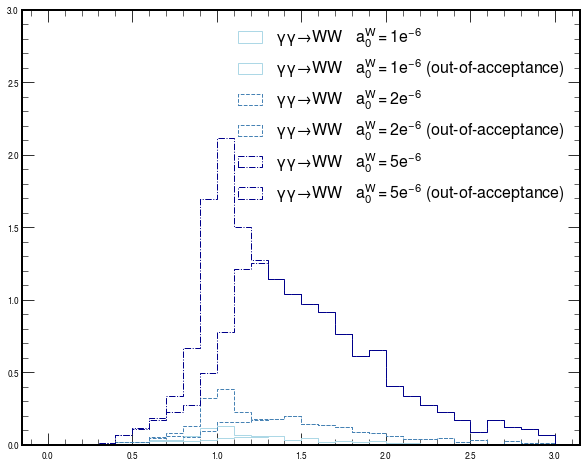

In [30]:
variation__ = "_nom"
var_str__ = {}
var_str__[ "_nom" ] = "_nom_nom"
var_weights__ = "nom"

fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=30, range=(0.,3.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.png", bbox_inches='tight' )

(0.0, 3.0)

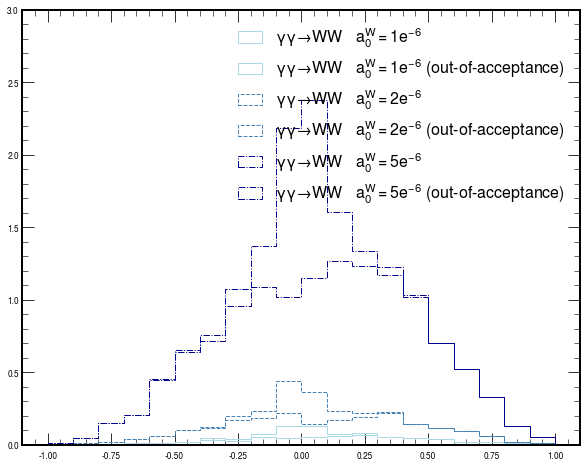

In [31]:
fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=20, range=(-1.,1.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 0.2)

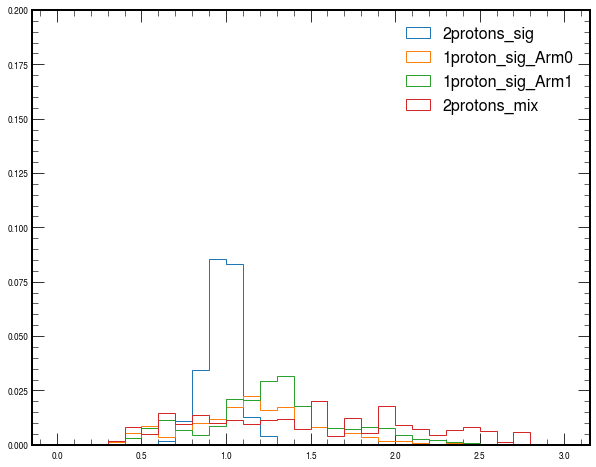

In [32]:
label_ = "GGToWW-AQGC-A0W1e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ][ variation__ ]
    plt.hist( df_selected_events__[ "R_MWW_MX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories[ label_ ][ var_weights__ ][ key_ ][ variation__ ],
              histtype='step', label=key_,
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( 0., 0.2 )
# plt.ylim( 0., 0.5 )
# plt.ylim( 0., 3. )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 0.2)

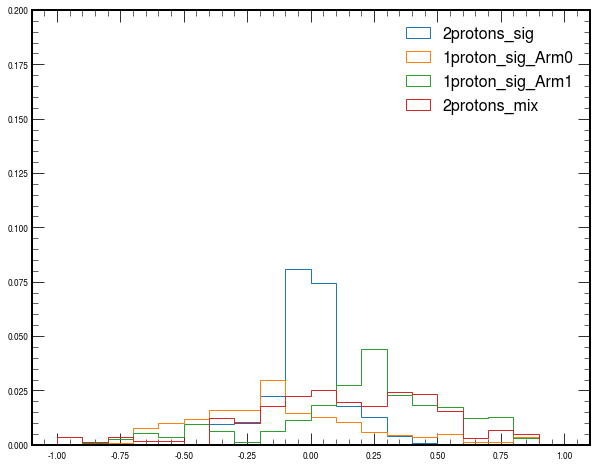

In [33]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ][ variation__ ]
    plt.hist( df_selected_events__[ "Diff_YWW_YX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories[ label_ ][ var_weights__ ][ key_ ][ variation__ ],
              histtype='step', label=key_,
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( 0., 0.2 )
# plt.ylim( 0., 0.5 )
# plt.ylim( 0., 3. )

In [34]:
# label_ = "GGToWW-AQGC-A0W5e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#     print ( key_ )
#     df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#     plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_out_acceptance_misreconstructed[ label_ ][ key_ ],
#               histtype='step', label=key_,
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )

In [35]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=30, range=(0.,3.) )
#     plt.hist( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ][ "ratioMWW_MX" ],
#               weights=weights_out_acceptance_misreconstructed_concat[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
#               bins=30, range=(0.,3.) )


# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

<ipython-input-37-d2a7fd20ab93>:23: RuntimeWarning: divide by zero encountered in true_divide
  axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
<ipython-input-37-d2a7fd20ab93>:23: RuntimeWarning: invalid value encountered in true_divide
  axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
<ipython-input-37-d2a7fd20ab93>:36: RuntimeWarning: invalid value encountered in true_divide
  axes[1,1].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
<ipython-input-37-d2a7fd20ab93>:23: RuntimeWarning: invalid value encountered in true_divide
  axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
<ipython-input-37-d2a7fd20ab93>:36: RuntimeWarning: invalid value encountered in true_divide
  axes[1,1].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),


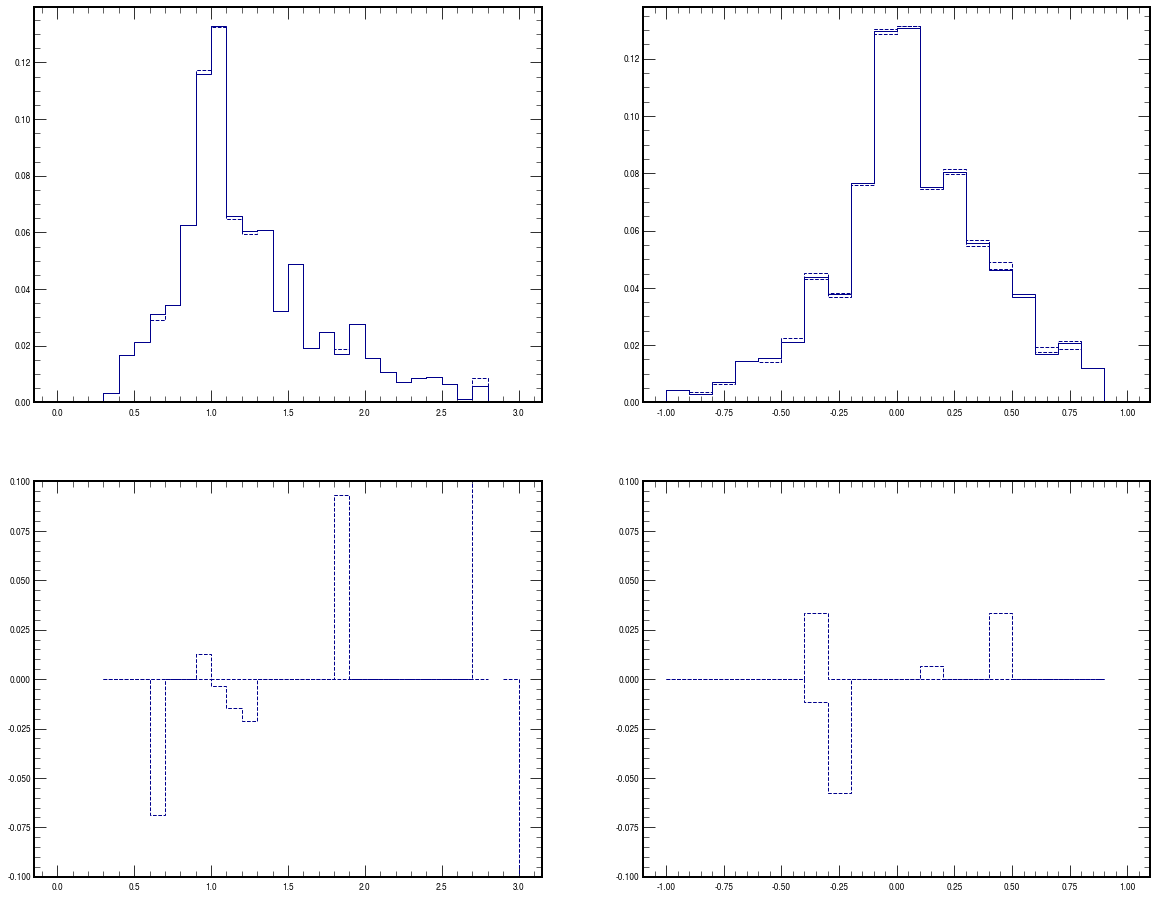

In [37]:
variations_ = [ "_nom", "_jes_up", "_jes_dw" ]
var_str__ = {}
for key_ in variations_:
    var_str__[ key_ ] = key_
# var_str__[ "_nom" ] = "_nom_nom"

fig, axes = plt.subplots( 2, 2, figsize=(2*10,2*8) )

color_ = "darkblue"
linestyles_ = [ "-", "--", "--" ]
for idx_, variation__ in enumerate( variations_ ):
    arr__ = df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ variation__ ] ]
    weights__ = weights_sig_plus_mix_2protons[ label_ ][ var_weights__ ][ variation__ ]
    counts__, bins__, _ = axes[0,0].hist( arr__, weights=weights__,
                                                 histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                                 bins=30, range=(0.,3.) )
    weights_nom__ = None
    if variation__ != "_nom":
        arr_nom__ = df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ][ "R_MWW_MX" + var_str__[ "_nom" ] ]
        weights_nom__ = weights_sig_plus_mix_2protons[ label_ ][ var_weights__ ][ "_nom" ]
        counts_nom__, bins_nom__ = np.histogram( arr_nom__, weights=weights_nom__, bins=30, range=(0.,3.) )
        bin_centers__ = ( bins__[:-1] + bins__[1:] ) / 2
        axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
                                       histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                       bins=30, range=(0.,3.) )
        axes[1,0].set_ylim( -0.10, 0.10 )
        
    arr__ = df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ variation__ ] ]
    counts__, bins__, _ = axes[0,1].hist( arr__, weights=weights__,
                                                 histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                                 bins=20, range=(-1.,1.) )
    if variation__ != "_nom":
        arr_nom__ = df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ][ "Diff_YWW_YX" + var_str__[ variation__ ] ]
        counts_nom__, bins_nom__ = np.histogram( arr_nom__, weights=weights_nom__, bins=20, range=(-1.,1.) )
        bin_centers__ = ( bins__[:-1] + bins__[1:] ) / 2
        axes[1,1].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
                                       histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                       bins=20, range=(-1.,1.) )
        axes[1,1].set_ylim( -0.10, 0.10 )
        

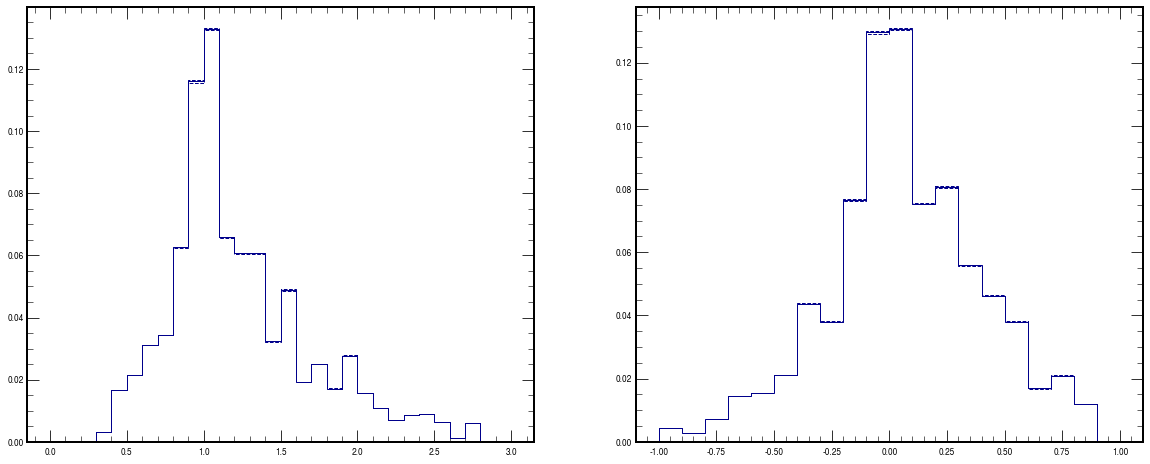

In [38]:
variations_weights_ = [ "nom", "sf_muon_id_up", "sf_muon_id_dw" ]
variation__ = "_nom"

fig, axes = plt.subplots( 1, 2, figsize=(2*10,8) )

color_ = "darkblue"
linestyles_ = [ "-", "--", "--" ]
for idx_, var_weights__ in enumerate( variations_weights_ ):
    axes[0].hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ variation__ ] ], weights=weights_sig_plus_mix_2protons[ label_ ][ var_weights__ ][ variation__ ],
                  histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=var_weights__,
                  bins=30, range=(0.,3.) )
    axes[1].hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ variation__ ] ], weights=weights_sig_plus_mix_2protons[ label_ ][ var_weights__ ][ variation__ ],
                  histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=var_weights__,
                  bins=20, range=(-1.,1.) )

R_MWW_MX
_nom_nom
_nom_p100
_nom_m100
_p100_nom
_p100_p100
_p100_m100
_m100_nom
_m100_p100
_m100_m100
[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.67764544e-03
 1.78838382e-02 2.16134241e-02 3.80484190e-02 4.89094181e-02
 1.03167785e-01 1.35703401e-01 1.41532522e-01 1.17171225e-01
 6.73953987e-02 6.65338318e-02 4.23637553e-02 5.01630092e-02
 2.07833420e-02 2.72734807e-02 2.05860406e-02 2.76929360e-02
 2.07130266e-02 1.13738599e-02 7.10801141e-03 9.21825314e-03
 1.01373894e-02 7.01681016e-03 1.30187894e-03 5.89000754e-03
 0.00000000e+00 1.30888722e-05]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.09156208e-03
 1.65936185e-02 1.44968793e-02 3.03283887e-02 2.10132361e-02
 4.47412580e-02 7.36138883e-02 8.73835746e-02 5.62981276e-02
 5.64095933e-02 4.59127667e-02 3.22524739e-02 3.42460378e-02
 1.58762356e-02 2.48796561e-02 1.67413470e-02 2.68419190e-02
 1.36139609e-02 9.86914175e-03 5.96737414e-03 8.04430778e-03
 8.25003431e-03 6.40551182e-03 1.30187894e-03 5.89000754e-03
 0.00000000e

<ipython-input-40-83711156b9e8>:100: RuntimeWarning: invalid value encountered in true_divide
  ratio_max_ = ( spline_max_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
<ipython-input-40-83711156b9e8>:101: RuntimeWarning: invalid value encountered in true_divide
  ratio_min_ = ( spline_min_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
<ipython-input-40-83711156b9e8>:100: RuntimeWarning: divide by zero encountered in true_divide
  ratio_max_ = ( spline_max_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
<ipython-input-40-83711156b9e8>:101: RuntimeWarning: invalid value encountered in true_divide
  ratio_min_ = ( spline_min_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]


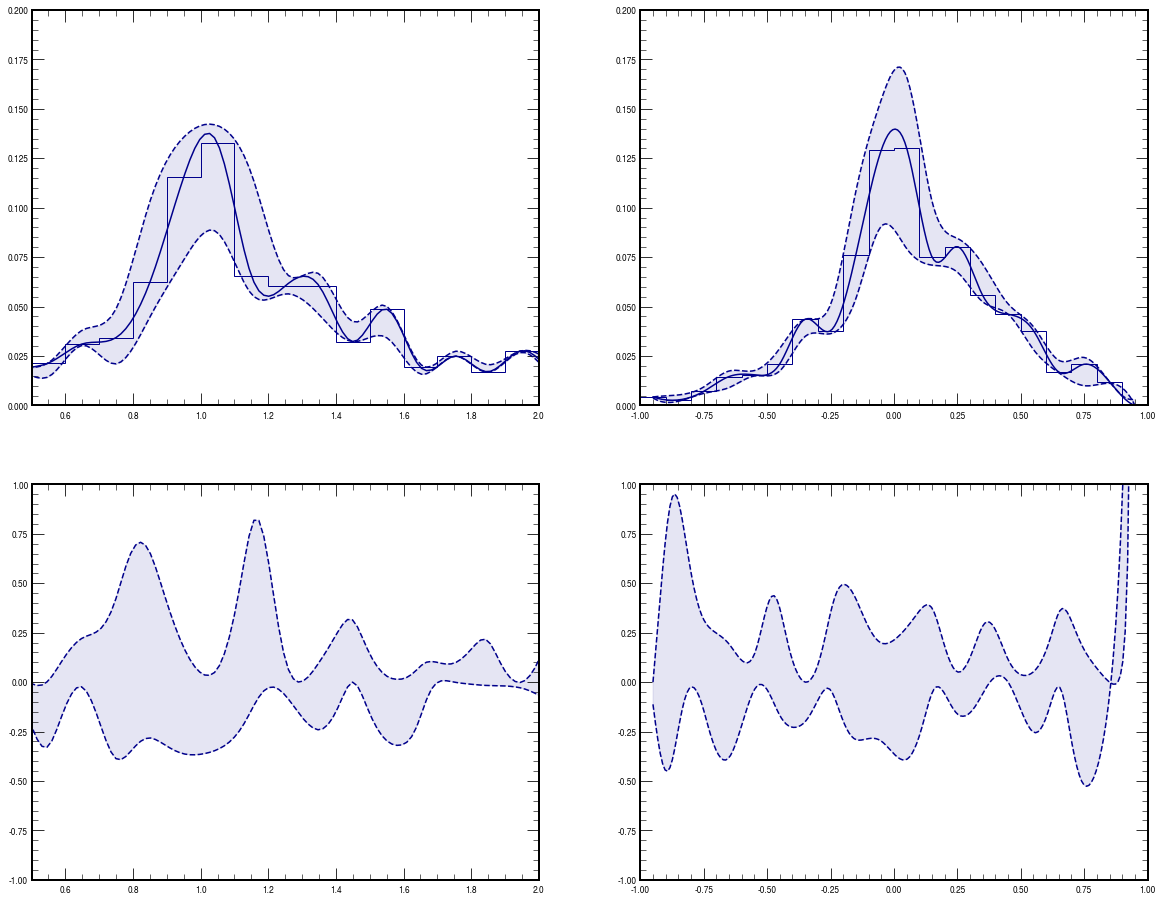

In [40]:
from scipy.interpolate import make_interp_spline

relative_uncertainty_ = True

# labels_xi_ = [ "_nom", "_p10", "_p30", "_p60", "_p100", "_m10", "_m30", "_m60", "_m100" ]
labels_xi_ = [ "_nom", "_p100", "_m100" ]
variations_ = []
for label0_ in labels_xi_:
    for label1_ in labels_xi_:
        variations_.append( label0_ + label1_ )

sel_str__ = {}
for key_ in variations_:
    sel_str__[ key_ ] = "_nom"

fig, axes = plt.subplots( 2, 2, figsize=(2*10,2*8) )

vars_ = {}
vars_[ "R_MWW_MX" ] = {}
vars_[ "R_MWW_MX" ][ "bins" ]  = 30
vars_[ "R_MWW_MX" ][ "range" ] = (0.,3.)
vars_[ "R_MWW_MX" ][ "xlim" ]  = (0.5,2.)
vars_[ "Diff_YWW_YX" ] = {}
vars_[ "Diff_YWW_YX" ][ "bins" ]  = 20
vars_[ "Diff_YWW_YX" ][ "range" ] = (-1.,1.)
vars_[ "Diff_YWW_YX" ][ "xlim" ]  = (-1.,1.)

ylim_ = (0.,0.2)
# ylim_ = (0.,0.5)
# ylim_ = (0.,3.)

color_ = "darkblue"
# linestyles_ = [ "-", "--", "--", "-.", "-." ]

idx_col_ = 0
max_ = {}
min_ = {}
spline_nom_ = {}
spline_max_ = {}
spline_min_ = {}
spline_nom_arr_ = {}
spline_max_arr_ = {}
spline_min_arr_ = {}
for var__ in vars_:
    print ( var__ )
    max_[ var__ ] = None
    min_[ var__ ] = None
    for idx_, variation__ in enumerate( variations_ ):
    #     counts_, bins_, _ = plt.hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ sel_str__[ variation__ ] ][ "R_MWW_MX" + variation__ ], weights=weights_sig_plus_mix_2protons[ label_ ][ sel_str__[ variation__ ] ],
    #                                   histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
    #                                   bins=30, range=(0.,3.) )
    #     counts_, bins_ = np.histogram( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ sel_str__[ variation__ ] ][ "R_MWW_MX" + variation__ ], weights=weights_sig_plus_mix_2protons[ label_ ][ sel_str__[ variation__ ] ], bins=30, range=(0.,3.) )
    #     bin_centers_ = ( bins_[:-1] + bins_[1:] ) / 2
    #     plt.plot( bin_centers_, counts_, color=color_, linestyle=linestyles_[ idx_ ] )
        if variation__ != "_nom":
            print ( variation__ )
            counts_, bins_ = np.histogram( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ sel_str__[ variation__ ] ][ var__ + variation__ ], weights=weights_sig_plus_mix_2protons[ label_ ][ var_weights__ ][ sel_str__[ variation__ ] ], bins=vars_[ var__ ][ "bins" ], range=vars_[ var__ ][ "range" ] )
#             counts_rebin_ = counts_[::2] + counts_[1::2]
#             bins_rebin_ = bins_[::2]
            
            if max_[ var__ ] is None: max_[ var__ ] = counts_.copy()
            if min_[ var__ ] is None: min_[ var__ ] = counts_.copy()
            msk__ = counts_ > max_[ var__ ]
            max_[ var__ ][ msk__ ] = counts_[ msk__ ]
            msk__ = counts_ < min_[ var__ ]
            min_[ var__ ][ msk__ ] = counts_[ msk__ ]

    print ( max_[ var__ ] )
    print ( min_[ var__ ] )
    counts_, bins_, _ = axes[0,idx_col_].hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ][ var__ + "_nom" ], weights=weights_sig_plus_mix_2protons[ label_ ][ var_weights__ ][ "_nom" ],
                                               histtype='step', color=color_, linestyle="-", label="_nom",
                                               bins=vars_[ var__ ][ "bins" ], range=vars_[ var__ ][ "range" ] )
    bin_centers_ = ( bins_[:-1] + bins_[1:] ) / 2
    # plt.plot( bin_centers_, counts_, color=color_, linestyle="-" )
    # plt.plot( bin_centers_, max_, color=color_, linestyle="--" )
    # plt.plot( bin_centers_, min_, color=color_, linestyle="--" )
#     bins_rebin_ = bins_[::2]
#     bins_rebin_ = bins_
#     bin_centers_rebin_ = ( bins_rebin_[:-1] + bins_rebin_[1:] ) / 2
    
    spline_nom_[ var__ ] = make_interp_spline( bin_centers_, counts_, k=3 )
    spline_max_[ var__ ] = make_interp_spline( bin_centers_, max_[ var__ ], k=3 )
    spline_min_[ var__ ] = make_interp_spline( bin_centers_, min_[ var__ ], k=3 )
    x_plot__ = np.linspace( bin_centers_[0], bin_centers_[-1], 200 )
#     rebin_factor_ = 1
    spline_nom_arr_[ var__ ] = spline_nom_[ var__ ]( x_plot__ )
    spline_max_arr_[ var__ ] = spline_max_[ var__ ]( x_plot__ )
    spline_min_arr_[ var__ ] = spline_min_[ var__ ]( x_plot__ )
    axes[0,idx_col_].plot( x_plot__, spline_nom_arr_[ var__ ], color=color_, linestyle="-" )
    axes[0,idx_col_].plot( x_plot__, spline_max_arr_[ var__ ], color=color_, linestyle="--" )
    axes[0,idx_col_].plot( x_plot__, spline_min_arr_[ var__ ], color=color_, linestyle="--" )
    axes[0,idx_col_].fill_between( x_plot__, spline_min_arr_[ var__ ], spline_max_arr_[ var__ ], color=color_, alpha=0.10 )
#     axes[0,idx_col_].set_xlim( 0.5, 2. )
    axes[0,idx_col_].set_xlim( vars_[ var__ ][ "xlim" ] )
#     axes[0,idx_col_].set_ylim( 0., 1. )
#     axes[0,idx_col_].set_ylim( 0., 3. )
    axes[0,idx_col_].set_ylim( ylim_ )

    if relative_uncertainty_:
        ratio_max_ = ( spline_max_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
        ratio_min_ = ( spline_min_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
        ratio_max_sel_ = pd.Series( ratio_max_ )
        ratio_max_sel_ = ratio_max_sel_[ ( x_plot__ >= 0.5 ) & ( x_plot__ <= 2.0 ) ]
        ratio_min_sel_ = pd.Series( ratio_min_ )
        ratio_min_sel_ = ratio_min_sel_[ ( x_plot__ >= 0.5 ) & ( x_plot__ <= 2.0 ) ]
        print ( ratio_max_sel_, ratio_max_sel_.mean() )
        print ( ratio_min_sel_, ratio_min_sel_.dropna().mean() )
        axes[1,idx_col_].plot( x_plot__, ratio_max_, color=color_, linestyle="--" )
        axes[1,idx_col_].plot( x_plot__, ratio_min_, color=color_, linestyle="--" )
        axes[1,idx_col_].fill_between( x_plot__, ratio_min_, ratio_max_, color=color_, alpha=0.10 )
    else:
        diff_max_ = ( spline_max_arr_[ var__ ] - spline_nom_arr_[ var__ ] )
        diff_min_ = ( spline_min_arr_[ var__ ] - spline_nom_arr_[ var__ ] )
        axes[1,idx_col_].plot( x_plot__, diff_max_, color=color_, linestyle="--" )
        axes[1,idx_col_].plot( x_plot__, diff_min_, color=color_, linestyle="--" )
        axes[1,idx_col_].fill_between( x_plot__, diff_min_, diff_max_, color=color_, alpha=0.10 )
#     axes[1,idx_col_].set_xlim( 0.5, 2. )
    axes[1,idx_col_].set_xlim( vars_[ var__ ][ "xlim" ] )
    axes[1,idx_col_].set_ylim( -1., 1. )
    idx_col_ += 1

In [ ]:
# arrays = [
#     ["bar","bar","foo","foo","baz","baz"],
#     ["one","one","two","two","one","one"]
# ]
# index = pd.MultiIndex.from_arrays(arrays, names=["first", "second"])
# df = pd.DataFrame( np.arange( 6*2 ).reshape( 6, 2 ), index=index, columns=['A','B'] )
# df_groupby = df.groupby( ["first","second"] )
# for name, group in df_groupby:
#     print ( name )
#     print ( group )
# df_groupby_apply_ = df_groupby.apply( lambda df__: ( df__['A'].iloc[0] * df__['B'].iloc[1] ) )
# print ( df_groupby_apply_ )
# df_nonduplicated = df[ ~df.index.duplicated(keep='first') ]
# df_nonduplicated.loc[ :, 'C' ] = df_groupby_apply_
# df_nonduplicated

In [ ]:
from scipy.interpolate import make_interp_spline
np.info( make_interp_spline )